In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from collections import namedtuple

import seaborn as sns

from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
### General Processing

In [3]:
main = pd.read_excel('movantanalysis.xlsx', sheet_name = 'KM Data Edits')
datapull = pd.read_excel('movantanalysis.xlsx', sheet_name = 'Data Pull Sheet')
aums = pd.read_excel('movantanalysis.xlsx', sheet_name = 'All Institution AUMs')
removed = pd.read_excel('movantanalysis.xlsx', sheet_name = 'Removed cases')

In [4]:
movant_categories = main["Movant ID"].str.split(".", n=2, expand = True)
main['Movant Group'] = movant_categories[0]+movant_categories[1]

In [5]:
main = main.merge(aums[['Institutional Movant', 'AUM']], how = 'left', left_on = 'Movant', right_on = 'Institutional Movant')

In [6]:
main = main.merge(datapull[['Ticker','Damage Bucket', "Filing Firm", "Lead Plaintiff"]], how = 'left', on = 'Ticker')

In [9]:
main = main.loc[:2866,:]

In [10]:
main["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"] = main["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"].str.replace("InS", "Ins")
main["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"] = main["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"].str.replace("ins", "Ins")
main["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"] = main["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"].str.replace("G-mix", "G-Mix")
main["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"] = main["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"].str.replace("ind", "Ind")
main["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"] = main["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"].str.replace("g-Ind", "G-Ind")

In [11]:
main["Small Case"] = 0
main.loc[main["Damage Bucket"].isin(["A","B"]), "Small Case"] = 1 
main.loc[main["Lead Plaintiff"].isna(),"Lead Plaintiff"] = "None"

In [12]:
def win(a, b):
    if a in b: return 1
    else: return 0

main = main.assign(win = main.apply(lambda row: win(row["Movant"], row["Lead Plaintiff"]), axis =1))

In [13]:
main["unopposed"] = 0
main.loc[main["Contested/\nUncontested"]=="Uncontested", "unopposed"] = 1

### I. MOVANT ANALYSIS BY REPORTED DAMAGES BY BUCKET

#### I. A. Number of Cases by Bucket

In [14]:
data_1a = datapull['Damage Bucket'].value_counts()

In [15]:
y_val = data_1a.sort_index()
x_val = data_1a.sort_index().index

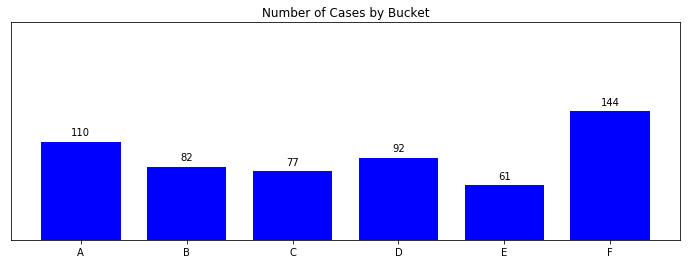

In [16]:
fig, ax = plt.subplots(figsize=(12,4))
width = 0.75
ind = np.arange(len((y_val)))
plt.title('Number of Cases by Bucket')
plt.yticks([], [])
ax.bar(x_val, y_val, width, color = "blue")

ax.set_ylim([0,y_val.max()+ 100])

rects = ax.patches

ax.yaxis.set_ticks_position('none')

for rect, label in zip(rects, y_val):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')
plt.show()

#### I.B. Analysis by Bucket

In [17]:
data_1b = datapull[['Damage Bucket', 'Docket Number','Total Damages', '% of Total Damages']].dropna()
data_1b['Total Damages'] = pd.to_numeric(data_1b['Total Damages'], errors='coerce').fillna(0)
data_1b['% of Total Damages'] = pd.to_numeric(data_1b['% of Total Damages'], errors='coerce').fillna(0)

In [18]:
data_1b_total = data_1b[['Damage Bucket', 'Docket Number','Total Damages']]
data_1b_describe_total = data_1b_total.pivot(index = 'Docket Number', columns = 'Damage Bucket', values = 'Total Damages')
data_1b_describe_total = data_1b_describe_total.describe()
data_1b_describe_total = pd.concat([data_1b_describe_total, pd.DataFrame(np.sort(data_1b_total.pivot(index = 'Docket Number', columns = 'Damage Bucket', values = 'Total Damages').fillna(0), axis = 0)[-2:,:], columns = data_1a.sort_index().index, index = ['Largest', '2nd Largest'])])

In [19]:
data_1b_bps = data_1b[['Damage Bucket', 'Docket Number','% of Total Damages']]
data_1b_describe_bps = data_1b_bps.pivot(index = 'Docket Number', columns = 'Damage Bucket', values = '% of Total Damages')
data_1b_describe_bps = data_1b_describe_bps.describe()
data_1b_describe_bps = pd.concat([data_1b_describe_bps, pd.DataFrame(np.sort(data_1b_bps.pivot(index = 'Docket Number', columns = 'Damage Bucket', values = '% of Total Damages'), axis = 0)[-2:,:], columns = data_1a.sort_index().index, index = ['Largest', '2nd Largest'])])

In [20]:
x_val = np.sort(data_1b['Damage Bucket'].unique())

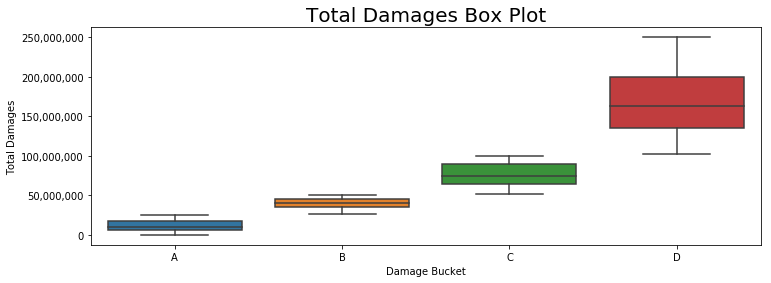

In [22]:
#### plt.clf()
plt.figure(figsize=(12,4))
plt.title("Total Damages Box Plot", size = 20)
ax = sns.boxplot(y = 'Total Damages', x = 'Damage Bucket', data = data_1b_total[~data_1b_total["Damage Bucket"].isin(["E", "F"])], order = x_val[:4], showfliers=False)
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda y, p: format(int(y), ',')))
plt.show()

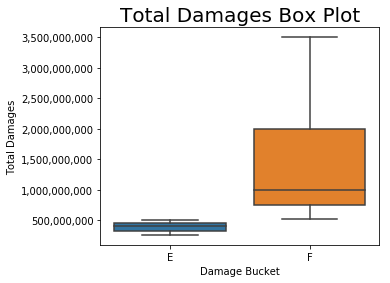

In [23]:
plt.figure(figsize=(5,4))
plt.title("Total Damages Box Plot", size = 20)
ax = sns.boxplot(y = 'Total Damages', x = 'Damage Bucket', data = data_1b_total[data_1b_total["Damage Bucket"].isin(["E", "F"])], order = x_val[4:6], showfliers=False)
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda y, p: format(int(y), ',')))
plt.show()

In [24]:
pd.options.display.float_format = '{:.0f}'.format
print("By Total Damage")
data_1b_describe_total

By Total Damage


Damage Bucket,A,B,C,D,E,F
count,110,82,77,92,61,144
mean,11848636,38815854,75870130,171467391,392967213,2385520833
std,7383037,6610158,14436203,42049539,76220506,4046534549
min,0,26000000,52000000,102000000,260000000,515000000
25%,5625000,35000000,65000000,135000000,325000000,747500000
50%,10000000,40000000,75000000,162500000,400000000,1000000000
75%,17750000,45000000,90000000,200000000,450000000,2000000000
max,25000000,50000000,100000000,250000000,500000000,25000000000
Largest,25000000,50000000,100000000,250000000,500000000,25000000000
2nd Largest,25000000,50000000,100000000,250000000,500000000,25000000000


In [25]:
pd.options.display.float_format = '{:,.2%}'.format
print("By BPS")
data_1b_describe_bps 

By BPS


Damage Bucket,A,B,C,D,E,F
count,"11,000.00%","8,200.00%","7,700.00%","9,200.00%","6,100.00%","14,400.00%"
mean,2.82%,1.14%,0.34%,0.49%,0.30%,0.40%
std,5.56%,2.06%,0.85%,1.02%,0.60%,1.03%
min,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
25%,0.09%,0.05%,0.01%,0.04%,0.01%,0.00%
50%,0.70%,0.33%,0.09%,0.16%,0.06%,0.04%
75%,2.57%,1.42%,0.29%,0.40%,0.28%,0.23%
max,34.72%,13.61%,6.80%,6.43%,3.06%,7.29%
Largest,nan%,nan%,nan%,nan%,nan%,nan%
2nd Largest,nan%,nan%,nan%,nan%,nan%,nan%


#### I.C. Win-Loss Analysis

In [ ]:
data_1c = main[["Movant", "Damage Bucket", "Type", "win"]]

#### I.C.1 Largest Movant

In [ ]:
data_1c1_wins = main.groupby("Movant")["win"].agg(["sum", "count"])
data_1c1_wins["win_rate"] = data_1c1_wins["sum"]/data_1c1_wins["count"]
data_1c1_losses = main.groupby("Movant")["Movant Loss"].sum()

In [ ]:
data_1c1_largest = data_1c1_losses[data_1c1_losses == data_1c1_losses.max()].index

In [ ]:
pd.options.display.float_format = '{:,.2f}'.format
print("The number of wins, cases and win rate of the largest movant is")
data_1c1_wins[data_1c1_wins.index.isin(data_1c1_largest)]

In [ ]:
#### I.C.2 Win Rate by Movant Category

In [ ]:
data_1c2 = data_1c.groupby("Type")["win"].agg(["sum", "count"])
data_1c2["win_rate"] = data_1c2["sum"]/data_1c2["count"]

In [ ]:
x_val = data_1c2.index
y_val = data_1c2.win_rate

In [ ]:

fig, ax = plt.subplots(figsize=(6,4))
width = 0.75
ind = np.arange(len((y_val)))
plt.title('Win Rate by Movant Category')
plt.yticks([], [])
ax.bar(x_val, y_val, width, color = "blue")

rects = ax.patches

ax.yaxis.set_ticks_position('none')

ax.set_ylim([0,y_val.max()+ 0.1])

for rect, label in zip(rects, y_val):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 0.01, "{:,.1%}".format(label),
            ha='center', va='bottom')
plt.show()

In [ ]:
#### I.C.3. Win Rate By Bucket

In [ ]:
data_1c3 = data_1c.groupby("Damage Bucket")["win"].agg(["sum", "count"])
data_1c3["win_rate"] = data_1c3["sum"]/data_1c3["count"]

In [ ]:
x_val = data_1c3.index
y_val = data_1c3.win_rate

In [ ]:

fig, ax = plt.subplots(figsize=(12,4))
width = 0.75
ind = np.arange(len((y_val)))
plt.title('Win Rate by Movant Category')
plt.yticks([], [])
ax.bar(x_val, y_val, width, color = "blue")

rects = ax.patches

ax.yaxis.set_ticks_position('none')

ax.set_ylim([0,y_val.max()+ 0.1])

for rect, label in zip(rects, y_val):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 0.01, "{:,.1%}".format(label),
            ha='center', va='bottom')
plt.show()

### II. ANALYSIS BY TYPE OF MOVANT

#### II. A. Number of Movants by Bucket

In [ ]:
data_2a = main["Damage Bucket"].value_counts()

In [ ]:
y_val = data_2a.sort_index()
x_val = data_2a.sort_index().index

In [ ]:
fig, ax = plt.subplots(figsize=(12,4))
width = 0.75
ind = np.arange(len((y_val)))
plt.title('Number of Movants by Bucket')
plt.yticks([], [])
ax.bar(x_val, y_val, width, color = "blue")

rects = ax.patches

ax.yaxis.set_ticks_position('none')

ax.set_ylim([0,y_val.max()+ 100])

for rect, label in zip(rects, y_val):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')
plt.show()

#### II.B. Number of Movants by Case

In [ ]:
data_2b = main.groupby("Ticker")["Movant ID"].count().reset_index()
data_2b_describe = data_2b.describe()

In [ ]:
pd.options.display.float_format = '{:.2f}'.format
data_2b_describe

#### II.C. Movant By Type By Bucket

In [ ]:
data_2c = main[["Damage Bucket", "Type (Ind, Ins, G-Ind, G-Ins, G-Mix)", "Movant ID"]]

In [ ]:
data_2c_grouped = data_2c.groupby(["Damage Bucket", "Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"])["Movant ID"].count().reset_index()

In [ ]:
data_2c_grouped

#### II.D. For Groups

In [ ]:
data_2d = main[["Movant Group", "Type (Ind, Ins, G-Ind, G-Ins, G-Mix)", "Movant Loss", "# of Movant Groups"]]
data_2d_groupcount = data_2d.groupby("Type (Ind, Ins, G-Ind, G-Ins, G-Mix)")["# of Movant Groups"].mean()
data_2d_groupcount = data_2d_groupcount.append(pd.Series(main["# of Movant Groups"].mean(), index = ["Total"]))
data_2d_loss = data_2d.groupby("Type (Ind, Ins, G-Ind, G-Ins, G-Mix)")["Movant Loss"].mean()
data_2d_loss = data_2d_loss.append(pd.Series(main["Movant Loss"].mean(), index = ["Total"]))

In [ ]:
data_2d = pd.concat([data_2d_groupcount, data_2d_loss], axis = 1)
data_2d.columns = ["Avg # of Members for Each Type", "Avg Losses"]

In [ ]:
print("Statistics by Type")
data_2d

#### II.E. For Unopposed Lead Plaintiff Motions

In [ ]:
data_2e = main[main["unopposed"]==1][["Damage Bucket","Movant","Movant Loss"]]

#### III.E.1. Number of Unopposed by Bucket

In [ ]:
data_2e1 = data_2e.groupby("Damage Bucket")["Movant"].count().reset_index()

In [ ]:
data_2e1

#### II.E.2 Average Loss of Unopposed by Bucket

In [ ]:
data_2e2 = data_2e.groupby("Damage Bucket")["Movant Loss"].mean().reset_index()

In [ ]:
data_2e2

#### II.F. Fight Analysis

In [ ]:
data_2f = main[["Small Case", "Type", "win"]]

In [ ]:
data2f_wins = data_2f.groupby(["Small Case", "Type"])["win"].agg(["sum", "count"])
data2f_wins["win_rate"] = data2f_wins["sum"]/  data2f_wins["count"]

In [ ]:
pd.options.display.float_format = '{:.1%}'.format
data2f_wins["win_rate"].reset_index()

### III. ANALYSIS BY INSTITUTIONAL MOVEMENT TYPE

#### III. A. Institutional Movants by Bucket

In [ ]:
data_3 = main[main["Type"]== "Institution"]

In [ ]:
data_3a = data_3.groupby('Damage Bucket')['Institutional Movant'].count()

In [ ]:
y_val = data_3a.sort_index()
x_val = data_3a.sort_index().index

In [ ]:
fig, ax = plt.subplots(figsize=(12,4))
width = 0.75
ind = np.arange(len((y_val)))
plt.title('Number of Institutional Movants by Bucket')
plt.yticks([], [])
ax.bar(x_val, y_val, width, color = "blue")

rects = ax.patches

ax.yaxis.set_ticks_position('none')

ax.set_ylim([0,y_val.max()+ 100])

for rect, label in zip(rects, y_val):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')
plt.show()

#### III.B Average Loss By Institutional Movant by Bucket
#### Note: Does not include institutional movants without losses (N/A)

In [ ]:
data_3b = data_3[['Damage Bucket',  "Type", 'Movant Loss']].dropna()
data_3b_describe = data_3b.pivot(columns = 'Damage Bucket', values = 'Movant Loss')
data_3b_describe = data_3b_describe.describe()

In [ ]:
pd.options.display.float_format = '{:.0f}'.format
data_3b_describe

#### III.C. Average Loss By Winning Institutional Movant by Bucket
#### Note: Does not include institutional movants without losses (N/A)

In [ ]:
data_3c = data_3[data_3.win==1][['Damage Bucket',  "Type", 'Movant Loss']].dropna()
data_3c_describe = data_3c.pivot(columns = 'Damage Bucket', values = 'Movant Loss')
data_3c_describe = data_3c_describe.describe()

In [ ]:
data_3c_describe

#### III.D. Average AUM of Institutional Movant by Bucket
##### Note: Count Includes Only Institutional Movants with AUMs (no N/As)

In [ ]:
data_3d = main[['Damage Bucket',  "Institutional Movant", "AUM"]].dropna()
data_3d_describe = data_3d.pivot(columns = 'Damage Bucket', values = 'AUM')
data_3d_describe = data_3d_describe.describe()

In [ ]:
pd.options.display.float_format = '{:.0f}'.format
data_3d_describe

#### III.E. Frequent Flyer Analysis

#### III.E.1. Movant Type

In [ ]:
data_3e = main[["Institutional Movant", "Damage Bucket", "Type (Ind, Ins, G-Ind, G-Ins, G-Mix)", 'Investor Frequent Flyer', 'Movant Loss', "Filing Firm"]]
data_3e = data_3e[~data_3e["Institutional Movant"].isna()]
data_3e.loc[(data_3e["Investor Frequent Flyer"].isna()),"Investor Frequent Flyer"] = "NotFF"

In [ ]:
data_3e1 = data_3e.groupby(["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)", "Investor Frequent Flyer"])["Institutional Movant"].count().reset_index().sort_values("Type (Ind, Ins, G-Ind, G-Ins, G-Mix)")

In [ ]:
y_val1 = data_3e1[data_3e1["Investor Frequent Flyer"]== "FF"]["Institutional Movant"]
y_val2 = data_3e1[data_3e1["Investor Frequent Flyer"]== "NotFF"]["Institutional Movant"]
x_val = data_3e1[data_3e1["Investor Frequent Flyer"]== "FF"]["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"]

In [ ]:
data_3e1

#### By Bucket

In [ ]:
data_3e2 = data_3e.groupby(["Damage Bucket", "Investor Frequent Flyer"])["Institutional Movant"].count().reset_index().sort_values("Damage Bucket")

In [ ]:
data_3e2

#### By Filing Firm

In [ ]:
data_3e["Filing Firm"] = data_3e["Filing Firm"].astype(str)

In [ ]:
data_3e3 = data_3e.groupby(["Filing Firm", "Investor Frequent Flyer"])["Institutional Movant"].count().reset_index().sort_values("Filing Firm")

In [ ]:
data_3e3

### APPENDIX

plt.clf()
plt.bar(x_val, y_val, color="b")
plt.title('Number of Cases by Bucket')
plt.show()

plt.clf()
fig, ax = plt.subplots(figsize=(12,4))
width = 0.75
ind = np.arange(len((y_val)))
ticks = np.array([2,4,6,8,10])

plt.title('Number of Institutional Movants by Bucket')

ax.bar(ticks, y_val1, width, color = "blue")
ax.bar(ticks + np.repeat(width, len(x_val)), y_val2, width, color = "orange")

plt.yticks([], [])

ax.set_ylim([0,y_val2.max()+ 100])

rects = ax.patches
ax.yaxis.set_ticks_position('none')

for i in range(len(x_val)):
    height = rects[i].get_height()
    ax.text(rects[i].get_x() + rects[i].get_width() / 2, height + 5, y_val1[i],
            ha='center', va='bottom')
    ax.text(rects[i].get_x() + rects[i].get_width() / 2, height + 5, y_val2[i],
            ha='center', va='bottom')
    
plt.xticks(ticks, c_val)

plt.show()

#### Number of Cases by Bucket

y_val = datapull['Damage Bucket'].value_counts().sort_index()
x_val = datapull['Damage Bucket'].value_counts().sort_index().index

plt.clf()
plt.bar(x_val, y_val, color="b")
plt.show()

bucketmovantcount = main['Damage Bucket'].value_counts().sort_index()

bucketmovantcount

fig, ax = plt.subplots() 

ind = np.arange(len(y_val))
bar_width = 0.75

ax.bar(ind, y_val, bar_width, col = 'b')
for i, v in enumerate(y):
    ax.text(v + 3, i + .25, str(v), color='blue')

plt.title('Number of Classes by Bucket', size = 16)

fig.tight_layout()

plt.show()

buckets = main["Damage Bucket"].sort_values().dropna().unique()
types = main["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"].sort_values().dropna().unique()

xval = buckets
yval = []

for i in buckets: 
    yval.append(data_2c_grouped[i][types])

plt.clf()
fig, ax = plt.subplots(figsize=(12,4))
width = 0.75
ind = np.arange(len((y_val)))
ticks = np.array([2,4,6,8,10])

plt.title('Number of Movants by Type for Each Bucket')

for i in yval
ax.bar(ticks, y_val1, width, color = "blue")
ax.bar(ticks + np.repeat(width, len(x_val)), y_val2, width, color = "orange")

plt.yticks([], [])

ax.set_ylim([0,y_val2.max()+ 100])

rects = ax.patches
ax.yaxis.set_ticks_position('none')

for i in range(len(x_val)):
    height = rects[i].get_height()
    ax.text(rects[i].get_x() + rects[i].get_width() / 10 + , height + 5, y_val1[i],
            ha='center', va='bottom')
    ax.text(rects[i].get_x() + rects[i].get_width() / i*2, height + 5, y_val2[i],
            ha='center', va='bottom')
    
plt.xticks(ticks, c_val)

plt.show()